In [1]:
import numpy as np
from datetime import datetime
import pandas as pd
from scipy.io import loadmat
from sklearn.model_selection import train_test_split
import h5py
from torch.utils.data.dataset import Dataset

In [2]:
from __future__ import print_function
from __future__ import division
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.models as models
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os,sys
import copy
print("PyTorch Version: ",torch.__version__)
print("Torchvision Version: ",torchvision.__version__)
torch.cuda.is_available()

PyTorch Version:  1.10.2+cu113
Torchvision Version:  0.11.3+cu113


True

In [3]:
def double_conv(in_channels, out_channels):
    return nn.Sequential(
        nn.Conv2d(in_channels, out_channels, 3, padding=1),
        nn.BatchNorm2d(out_channels),
        nn.ReLU(inplace=True),
        nn.Conv2d(out_channels, out_channels, 3, padding=1),
        nn.BatchNorm2d(out_channels),
        nn.ReLU(inplace=True)
    )   

class UNetSmallVeriCell(nn.Module):
    def __init__(self, in_channels,out_channels,n_class,dropout=0.2):
        super().__init__()
        self.num_init_channels = 4
        self.dconv_down1 = double_conv(in_channels, self.num_init_channels)
        self.dconv_down2 = double_conv(self.num_init_channels, self.num_init_channels*2)
        self.dconv_down3 = double_conv(self.num_init_channels*2, self.num_init_channels*4)
        self.dconv_down4 = double_conv(self.num_init_channels*4, self.num_init_channels*8)
        self.dconv_down5 = double_conv(self.num_init_channels*8, self.num_init_channels*16)

        self.maxpool = nn.MaxPool2d(2)
        self.upsample = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)        
        
        self.dconv_up4 = double_conv(self.num_init_channels*16+self.num_init_channels*8, self.num_init_channels*8)
        self.dconv_up3 = double_conv(self.num_init_channels*8+self.num_init_channels*4, self.num_init_channels*4)
        self.dconv_up2 = double_conv(self.num_init_channels*4+self.num_init_channels*2, self.num_init_channels*2)
        self.dconv_up1 = double_conv(self.num_init_channels*2+self.num_init_channels, self.num_init_channels)
        
        self.conv_last = nn.Conv2d(self.num_init_channels, out_channels, 1)
        self.fc1 = nn.Linear(1120 ,128)
        self.bn_fc1 = nn.BatchNorm1d(128)
        self.out1 = nn.Linear(128, n_class)
    
        self.dropout1 = nn.Dropout(dropout)
        self.bn2d = nn.BatchNorm2d(num_features=self.num_init_channels*16, affine=False)
        self.relu = nn.ReLU()
        
    def forward(self, x):
        conv1 = self.dconv_down1(x)
        x = self.maxpool(conv1)
        conv2 = self.dconv_down2(x)
        x = self.maxpool(conv2)
        conv3 = self.dconv_down3(x)
        x = self.maxpool(conv3)   
        conv4 = self.dconv_down4(x)
        x = self.maxpool(conv4) 
        
#         x = self.bn2d(x)
         #Classifier
        flatten = x.view(x.size(0),-1)
#         print('fc:',flatten.size())
        y = self.fc1(flatten)
#         y = self.bn_fc1(y)
        y = self.relu(y)
        y = self.dropout1(y)

        y = self.out1(y)
#         print('out:',x.size())
#         prediction = nn.functional.log_softmax(y,dim=1)
        prediction = y
    
        x = self.dconv_down5(x)
    
        x = self.upsample(x)
        x = torch.cat([x, conv4], dim=1)
        x = self.dconv_up4(x)
        x = self.upsample(x)        
        x = torch.cat([x, conv3], dim=1)        
        x = self.dconv_up3(x)
        x = self.upsample(x)
        x = torch.cat([x, conv2], dim=1)  
        x = self.dconv_up2(x)
        x = self.upsample(x)     
        x = torch.cat([x, conv1], dim=1)   
        x = self.dconv_up1(x)
        out = self.conv_last(x)
        return out,prediction

In [4]:
def init_weights(m):
# print(m)
    if type(m) == nn.Linear or type(m) == nn.Conv2d:
        m.weight.data.normal_(0, 0.0001)
# print(m.weight)

# net = nn.Sequential(nn.Linear(2, 2), nn.Linear(2, 2))
# net.apply(init_weights)

In [5]:
from torchsummary import summary

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = UNetSmallVeriCell(1,1,2)
model.apply(init_weights)
model = model.to(device)
# model
summary(model, input_size=(1, 80, 112))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 4, 80, 112]              40
       BatchNorm2d-2           [-1, 4, 80, 112]               8
              ReLU-3           [-1, 4, 80, 112]               0
            Conv2d-4           [-1, 4, 80, 112]             148
       BatchNorm2d-5           [-1, 4, 80, 112]               8
              ReLU-6           [-1, 4, 80, 112]               0
         MaxPool2d-7            [-1, 4, 40, 56]               0
            Conv2d-8            [-1, 8, 40, 56]             296
       BatchNorm2d-9            [-1, 8, 40, 56]              16
             ReLU-10            [-1, 8, 40, 56]               0
           Conv2d-11            [-1, 8, 40, 56]             584
      BatchNorm2d-12            [-1, 8, 40, 56]              16
             ReLU-13            [-1, 8, 40, 56]               0
        MaxPool2d-14            [-1, 8,

In [6]:
from collections import defaultdict
import torch.nn.functional as F

In [7]:
Datadir = "I:\\VeriCells03282022\\Dataset"

In [8]:
import os
def datapreparation(Datadir):
#     Datapath = []
    trainlabel = []
    trainpath = []
    
    fpath = []
    traindir = Datadir + "\\Lym\\ImageRaw"
    for dirpath, dirnames, filenames in os.walk(traindir):
        for filename in [f for f in filenames if f.endswith(".mat")]:
            tempfpath =os.path.join(dirpath, filename)
            fpath.append(tempfpath)
    datalength = list(range(0,len(fpath)))
    train = list(range(0,len(fpath)))
    print('Lymphocytes data length: %d' %(len(train)))
    for i in train:
        trainpath.append(fpath[i])
        trainlabel.append(0)
        
    fpath = []
    traindir = Datadir + "\\Gra\\ImageRaw"
    for dirpath, dirnames, filenames in os.walk(traindir):
        for filename in [f for f in filenames if f.endswith(".mat")]:
            tempfpath =os.path.join(dirpath, filename)
            fpath.append(tempfpath)
    datalength = list(range(0,len(fpath)))
    train = list(range(0,len(fpath)))
    print('Granulocytes data length: %d' %(len(train)))
    for i in train:
        trainpath.append(fpath[i])
        trainlabel.append(1)
    
    fpath = []
    traindir = Datadir + "\\Mon\\ImageRaw"
    for dirpath, dirnames, filenames in os.walk(traindir):
        for filename in [f for f in filenames if f.endswith(".mat")]:
            tempfpath =os.path.join(dirpath, filename)
            fpath.append(tempfpath)
    datalength = list(range(0,len(fpath)))
    train = list(range(0,len(fpath)))
    print('Monocytes data length: %d' %(len(train)))
    for i in train:
        trainpath.append(fpath[i])
        trainlabel.append(2)
        
    return trainpath,trainlabel

In [9]:
X, Y = datapreparation(Datadir)

Lymphocytes data length: 6788
Granulocytes data length: 5001
Monocytes data length: 6087


In [10]:
from sklearn.model_selection import StratifiedKFold
kfold = StratifiedKFold(n_splits=5, random_state=42, shuffle=True)
trainindex = {}
testindex = {}
i = 0
for train_index, test_index in kfold.split(X,Y):
    print("Train Index: ", train_index, "\n")
    print("Test Index: ", test_index)
    trainindex[i] = train_index
    testindex[i] = test_index
    i = i + 1
#fold - 0
# print(trainindex[1])
# indices = trainindex[1]
trainpath =[X[i] for i in trainindex[1]]
testpath =[X[i] for i in testindex[1]]

Train Index:  [    0     1     3 ... 17872 17873 17875] 

Test Index:  [    2     6     8 ... 17857 17862 17874]
Train Index:  [    0     1     2 ... 17872 17873 17874] 

Test Index:  [    3     4    10 ... 17863 17865 17875]
Train Index:  [    0     1     2 ... 17873 17874 17875] 

Test Index:  [    9    12    14 ... 17850 17854 17866]
Train Index:  [    2     3     4 ... 17873 17874 17875] 

Test Index:  [    0     1    16 ... 17859 17861 17871]
Train Index:  [    0     1     2 ... 17871 17874 17875] 

Test Index:  [    5     7    19 ... 17870 17872 17873]


In [11]:
import scipy.io
import random

class MyDataset(Dataset):
    def __init__(self, mat_paths, transforms=None):
        self.paths = mat_paths
        self.transforms = transforms
        
    def __getitem__(self, index):
        data = scipy.io.loadmat(self.paths[index])
        x = np.array(data['RGB'])
#         x = x[4:116,:]
        x = x[:,4:116]
        if x.max() == 0:
            x = x
        else:
            x = (x-x.min())/(x.max()-x.min())
        if 'Lym' in self.paths[index]:
            label = int(0)
        elif 'Gra' in self.paths[index]:
            label = int(1)
        elif 'Mon' in self.paths[index]:
            label = int(2)
        p1 = random.uniform(0, 1)
        p2 = random.uniform(0, 1)
            
        x = torch.from_numpy(x)
        x = x.type(torch.FloatTensor)
        x = x.unsqueeze(dim = 0)
        if p1 >=0.5:
            x = torch.flip(x, dims=[1])
            
        if p2 >=0.5:
            x = torch.flip(x, dims=[2])      
        return x,label,index
    
    def __len__(self):
        return len(self.paths)

In [12]:
#actual training
image_datasets = {}
image_datasets['train'] = MyDataset(trainpath)
image_datasets['val'] = MyDataset(testpath)

# test_datasets['val'] = MyDataset(testpath)
print('training data volume: ', image_datasets['train'].__len__())
print('validation data volume: ', image_datasets['val'].__len__())

# print('mini-training data volume: ', mini_datasets['train'].__len__())
# print('mini-validation data volume: ', mini_datasets['val'].__len__())

CellName = ['Lymphocytes','Granulocytes','Monocytes']
image_datasets['train'].__getitem__(0)[0].shape
[ImgTensor,ImgLabel,ImgIndex] = image_datasets['train'].__getitem__(0)
print('Cell Label: ',CellName[ImgLabel])
print('image tensor shape: ', ImgTensor.shape)
print('image tensor dtype: ', ImgTensor.dtype)
image_datasets['train'].__getitem__(0)[0]

#Visualize image stacks
from mpl_toolkits.axes_grid1 import make_axes_locatable
image = np.squeeze(ImgTensor.numpy())
print('image shape: ', image.shape)

training data volume:  14301
validation data volume:  3575
Cell Label:  Lymphocytes
image tensor shape:  torch.Size([1, 80, 112])
image tensor dtype:  torch.float32
image shape:  (80, 112)


In [13]:
#Visualize image stacks
from mpl_toolkits.axes_grid1 import make_axes_locatable


def DisplayImage(img,LimMin,LimMax,Idx):  
    fig4 = plt.imshow(np.squeeze(img),vmin=LimMin, vmax=LimMax, cmap ='gray')
    plt.title('Transmission ' + str(Idx))
    ax = plt.gca()
    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size="5%", pad=0.05)
    plt.colorbar(fig4, cax=cax)
    plt.show()

image tensor shape:  torch.Size([1, 80, 112])
image tensor dtype:  torch.float32
image tensor index:  12000
Cell Label:  Monocytes
image shape:  (80, 112)


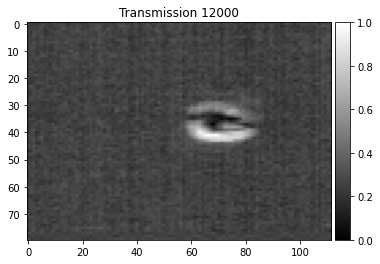

In [14]:
ImgIdx = 12000
image_datasets['train'].__getitem__(ImgIdx)[0].shape
ImgTensor = 0
ImgMask = 0
[ImgTensor,ImgLabel,ImgIdx] = image_datasets['train'].__getitem__(ImgIdx)
# image = np.transpose(ImgTensor.numpy(), (1,2,0))
# print('Cell Label: ',CellName[ImgLabel])
print('image tensor shape: ', ImgTensor.shape)
print('image tensor dtype: ', ImgTensor.dtype)
print('image tensor index: ', ImgIdx)
print('Cell Label: ',CellName[ImgLabel])

#Visualize image stacks
from mpl_toolkits.axes_grid1 import make_axes_locatable
image = 0
image = np.squeeze(ImgTensor.numpy())
print('image shape: ', image.shape)
DisplayImage(image,image.min(),image.max(),ImgIdx)

In [15]:
def calc_loss(out, prediction, target, original, metrics, num_epochs, MSE_weight=0.5):
    if num_epochs < 20:
        CE = 0
        MSE = F.mse_loss(out, original)
        loss = MSE 
        metrics['CE'] += CE
    else:
        CE = F.cross_entropy(prediction, target)
#     BCE = F.binary_cross_entropy_with_logits(prediction, target)
#     out = torch.sigmoid(out)
        MSE = F.mse_loss(out, original)
    
        loss = MSE * MSE_weight + CE * (1 - MSE_weight)
#     loss = MSE * MSE_weight + CE
    
        metrics['CE'] += CE.data.cpu().numpy() * target.size(0)
    metrics['MSE'] += MSE.data.cpu().numpy() * target.size(0)
    metrics['loss'] += loss.data.cpu().numpy() * target.size(0)
    
    return loss

def print_metrics(metrics, epoch_samples, phase):    
    outputs = []
    for k in metrics.keys():
        outputs.append("{}: {:4f}".format(k, metrics[k] / epoch_samples))
        
    print("{}: {}".format(phase, ", ".join(outputs)))   

In [16]:
def train_model(model, dataloaders, optimizer1, optimizer2, scheduler1, scheduler2, num_epochs=25):
    start = datetime.now()
    val_acc_history = []
    train_acc_history = []
    val_Bacc_history = []
    train_Bacc_history = []
    val_loss_history = []
    train_loss_history = []
    val_MSEloss_history = []
    lr_history = []
    best_acc = 0.0
    best_model_wts = copy.deepcopy(model.state_dict())
    best_loss = 1e10

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)
        
        since = time.time()

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                if epoch < 5:
                    for param_group in optimizer1.param_groups:
                        print("LR", param_group['lr'])
                        lr_history.append(param_group['lr'])
                else:
                    for param_group in optimizer2.param_groups:
                        print("LR", param_group['lr'])
                        lr_history.append(param_group['lr'])
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            metrics = defaultdict(float)
            epoch_samples = 0
#             running_loss = 0.0
            running_corrects = 0
            confusion_matrix = torch.zeros(3, 3)
            for inputs, labels,index in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)             

                # zero the parameter gradients
                if epoch < 5:
                    optimizer1.zero_grad()
                else:
                    optimizer2.zero_grad()
                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs,predictions = model(inputs)
                    prediction = nn.functional.log_softmax(predictions,dim=1)
                    loss = calc_loss(outputs, predictions,labels,inputs, metrics, epoch,MSE_weight = 0.1)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        if epoch < 5:
                            optimizer1.step()
                        else:
                            optimizer2.step()
                _, preds = torch.max(predictions, 1)
                # statistics
                epoch_samples += inputs.size(0)
                # statistics
                for t, p in zip(labels.view(-1), preds.view(-1)):
                    confusion_matrix[t.long(), p.long()] += 1
                  
                running_corrects += torch.sum(preds == labels.data)
            
            
            confusionMat = np.asarray(confusion_matrix)
            sumconfusion = np.sum(confusionMat,axis = 1).T

            summat = np.tile(sumconfusion,(3,1)).T
            # print(test)
            percentconfusion = np.divide(confusionMat,summat)
            epoch_acc_balanced = np.sum(np.diagonal(percentconfusion))/3
            print_metrics(metrics, epoch_samples, phase)
            epoch_loss = metrics['loss'] / epoch_samples
            epoch_acc = running_corrects.double() / epoch_samples
            print('{} Acc: {:.4f}'.format(phase, epoch_acc))
            print('{} Bal. Acc: {:.4f}'.format(phase, epoch_acc_balanced))
            # deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                print("saving best model")
                best_acc = epoch_acc
                best_loss = epoch_loss
                best_model_wts = copy.deepcopy(model.state_dict())
            if phase == 'val':
                val_acc_history.append(epoch_acc)
                val_Bacc_history.append(epoch_acc_balanced)
                val_loss_history.append(epoch_loss)
                val_MSEloss_history.append(metrics['MSE']/epoch_samples)
                if epoch < 5:
                    scheduler1.step(epoch_loss)
                elif epoch > num_epochs * (1/3):
                    scheduler2.step(epoch_loss)

            if phase == 'train':
                train_acc_history.append(epoch_acc)
                train_Bacc_history.append(epoch_acc_balanced)
                train_loss_history.append(epoch_loss)
#             if epoch_acc == 1:
#                 break
        
        if epoch > 3 and val_MSEloss_history[-1] > 1.8e7 :
                break
        print("Total time: %s" %(datetime.now() - start))
        time_elapsed = time.time() - since
        print('Epoch time: {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))
            
    print('Best val loss: {:4f}'.format(best_loss))
    print('Best val acc: {:4f}'.format(best_acc))
    # load best model weights
    model.load_state_dict(best_model_wts)
    return model,train_acc_history,train_loss_history,val_acc_history,val_loss_history,lr_history,train_Bacc_history,val_Bacc_history

In [17]:
print("Initializing Datasets and Dataloaders...")
# Number of classes in the dataset
num_classes = 3

# Batch size for training (change depending on how much memory you have)
batch_size = 256
# Create training and validation datasets
# image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x), data_transforms[x]) for x in ['train', 'val']}
# Create training and validation dataloaders
dataloaders_dict = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=batch_size, shuffle=True, num_workers=0) for x in ['train', 'val']}

# Detect if we have a GPU available
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

Initializing Datasets and Dataloaders...


In [23]:
import torch
import torch.optim as optim
from torch.optim import lr_scheduler
import copy

for runs in range (0,1):
    print("Fold-",str(runs),": Initializing Datasets and Dataloaders...")
    #Kfold
    trainpath =[X[i] for i in trainindex[runs]]
    testpath =[X[i] for i in testindex[runs]]
    image_datasets = {}
    image_datasets['train'] = MyDataset(trainpath)
    image_datasets['val'] = MyDataset(testpath)

    dataloaders_dict = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=batch_size, shuffle=True, num_workers=0) for x in ['train', 'val']}

    # Detect if we have a GPU available
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    num_class = 3
    in_channel = 1
    out_channel = 1
    num_epochs = 150
    loss_hist_train = []
    while (len(loss_hist_train)<num_epochs/2):
        model = UNetSmallVeriCell(in_channel,out_channel,num_class)
        model.apply(init_weights)
        model = model.to(device)

        # freeze backbone layers
        # Comment out to finetune further
        # for l in model.base_layers:
        #     for param in l.parameters():
        #         param.requires_grad = False

        optimizer_ft1 = optim.Adam(model.parameters(), lr=1e-5,betas = (0.9, 0.999),eps=1e-08,weight_decay=0)
        optimizer_ft2 = optim.Adam(model.parameters(), lr=1e-3,betas = (0.9, 0.999),eps=1e-08,weight_decay=0)
        # optimizer_ft1 = optim.Adadelta(model.parameters(), lr=1e-3, rho=0.9, eps=1e-06, weight_decay=0)
        # optimizer_ft2 = optim.Adadelta(model.parameters(), lr=1e-3, rho=0.9, eps=1e-06, weight_decay=0)
        # exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=10, gamma=0.1) 
        exp_lr_scheduler1 = lr_scheduler.ReduceLROnPlateau(optimizer_ft1, mode='min', factor=0.5, patience=5, verbose=True, threshold=0.0001, threshold_mode='rel', cooldown=1, min_lr=1e-7, eps=1e-08)
        exp_lr_scheduler2 = lr_scheduler.ReduceLROnPlateau(optimizer_ft2, mode='min', factor=0.5, patience=5, verbose=True, threshold=0.0001, threshold_mode='rel', cooldown=1, min_lr=1e-7, eps=1e-08)       
        model, scratch_hist_train,loss_hist_train,scratch_hist_val, loss_hist_val,lr_hist,train_Bacc_hist,val_Bacc_hist = train_model(model, dataloaders_dict,optimizer_ft1, optimizer_ft2, exp_lr_scheduler1,exp_lr_scheduler2, num_epochs)
        print('model diverges, reinitializing training....\n')
        print("Fold-",str(runs),": Initializing Datasets and Dataloaders...")
        

Fold- 0 : Initializing Datasets and Dataloaders...
Epoch 0/149
----------
LR 1e-05
train: CE: 0.000000, MSE: 0.587687, loss: 0.587687
train Acc: 0.3405
train Bal. Acc: 0.3333
val: CE: 0.000000, MSE: 0.590888, loss: 0.590888
val Acc: 0.3406
val Bal. Acc: 0.3333
saving best model
Total time: 0:00:16.235862
Epoch time: 0m 16s
Epoch 1/149
----------
LR 1e-05
train: CE: 0.000000, MSE: 0.584284, loss: 0.584284
train Acc: 0.3405
train Bal. Acc: 0.3333
val: CE: 0.000000, MSE: 0.585900, loss: 0.585900
val Acc: 0.3406
val Bal. Acc: 0.3333
Total time: 0:00:31.462803
Epoch time: 0m 15s
Epoch 2/149
----------
LR 1e-05
train: CE: 0.000000, MSE: 0.581243, loss: 0.581243
train Acc: 0.3405
train Bal. Acc: 0.3333
val: CE: 0.000000, MSE: 0.582832, loss: 0.582832
val Acc: 0.3406
val Bal. Acc: 0.3333
Total time: 0:00:46.674404
Epoch time: 0m 15s
Epoch 3/149
----------
LR 1e-05
train: CE: 0.000000, MSE: 0.578326, loss: 0.578326
train Acc: 0.3405
train Bal. Acc: 0.3333
val: CE: 0.000000, MSE: 0.578759, loss:

val: CE: 0.297884, MSE: 0.002026, loss: 0.268298
val Acc: 0.8806
val Bal. Acc: 0.8912
Total time: 0:08:11.613779
Epoch time: 0m 15s
Epoch 32/149
----------
LR 0.001
train: CE: 0.202366, MSE: 0.001262, loss: 0.182256
train Acc: 0.9259
train Bal. Acc: 0.9314
val: CE: 2.052091, MSE: 0.001988, loss: 1.847080
val Acc: 0.6177
val Bal. Acc: 0.6469
Total time: 0:08:27.034540
Epoch time: 0m 15s
Epoch 33/149
----------
LR 0.001
train: CE: 0.196086, MSE: 0.001257, loss: 0.176603
train Acc: 0.9277
train Bal. Acc: 0.9331
val: CE: 0.219293, MSE: 0.002433, loss: 0.197607
val Acc: 0.9203
val Bal. Acc: 0.9259
Total time: 0:08:42.339507
Epoch time: 0m 15s
Epoch 34/149
----------
LR 0.001
train: CE: 0.179508, MSE: 0.001323, loss: 0.161689
train Acc: 0.9368
train Bal. Acc: 0.9415
val: CE: 0.341724, MSE: 0.003599, loss: 0.307911
val Acc: 0.8708
val Bal. Acc: 0.8844
Total time: 0:08:57.846546
Epoch time: 0m 16s
Epoch 35/149
----------
LR 0.001
train: CE: 0.169974, MSE: 0.001199, loss: 0.153096
train Acc: 0.

train: CE: 0.042421, MSE: 0.000736, loss: 0.038253
train Acc: 0.9859
train Bal. Acc: 0.9871
val: CE: 0.052210, MSE: 0.000617, loss: 0.047050
val Acc: 0.9838
val Bal. Acc: 0.9848
saving best model
Total time: 0:16:26.371756
Epoch time: 0m 16s
Epoch 64/149
----------
LR 0.0005
train: CE: 0.039595, MSE: 0.000748, loss: 0.035710
train Acc: 0.9862
train Bal. Acc: 0.9873
val: CE: 0.076200, MSE: 0.000595, loss: 0.068639
val Acc: 0.9757
val Bal. Acc: 0.9769
Total time: 0:16:42.154683
Epoch time: 0m 16s
Epoch 65/149
----------
LR 0.0005
train: CE: 0.038220, MSE: 0.000734, loss: 0.034472
train Acc: 0.9866
train Bal. Acc: 0.9878
val: CE: 0.198820, MSE: 0.000631, loss: 0.179001
val Acc: 0.9340
val Bal. Acc: 0.9347
Total time: 0:16:58.523298
Epoch time: 0m 16s
Epoch 66/149
----------
LR 0.0005
train: CE: 0.038406, MSE: 0.000699, loss: 0.034635
train Acc: 0.9864
train Bal. Acc: 0.9875
val: CE: 0.055075, MSE: 0.000545, loss: 0.049622
val Acc: 0.9815
val Bal. Acc: 0.9828
Total time: 0:17:14.330999
Epo

train: CE: 0.021168, MSE: 0.000615, loss: 0.019113
train Acc: 0.9933
train Bal. Acc: 0.9939
val: CE: 0.039576, MSE: 0.000493, loss: 0.035667
val Acc: 0.9871
val Bal. Acc: 0.9882
Total time: 0:24:31.231243
Epoch time: 0m 16s
Epoch 95/149
----------
LR 6.25e-05
train: CE: 0.019034, MSE: 0.000592, loss: 0.017190
train Acc: 0.9936
train Bal. Acc: 0.9941
val: CE: 0.041641, MSE: 0.000502, loss: 0.037527
val Acc: 0.9883
val Bal. Acc: 0.9893
Total time: 0:24:46.728724
Epoch time: 0m 15s
Epoch 96/149
----------
LR 6.25e-05
train: CE: 0.022267, MSE: 0.000612, loss: 0.020101
train Acc: 0.9918
train Bal. Acc: 0.9925
val: CE: 0.036181, MSE: 0.000570, loss: 0.032620
val Acc: 0.9905
val Bal. Acc: 0.9913
saving best model
Total time: 0:25:02.275523
Epoch time: 0m 16s
Epoch 97/149
----------
LR 6.25e-05
train: CE: 0.020924, MSE: 0.000594, loss: 0.018891
train Acc: 0.9924
train Bal. Acc: 0.9931
val: CE: 0.035536, MSE: 0.000496, loss: 0.032032
val Acc: 0.9885
val Bal. Acc: 0.9895
Total time: 0:25:17.6057

train: CE: 0.017928, MSE: 0.000573, loss: 0.016192
train Acc: 0.9942
train Bal. Acc: 0.9947
val: CE: 0.035208, MSE: 0.000467, loss: 0.031734
val Acc: 0.9905
val Bal. Acc: 0.9913
Total time: 0:32:22.994358
Epoch time: 0m 16s
Epoch 126/149
----------
LR 7.8125e-06
train: CE: 0.017629, MSE: 0.000583, loss: 0.015925
train Acc: 0.9945
train Bal. Acc: 0.9949
val: CE: 0.034051, MSE: 0.000466, loss: 0.030692
val Acc: 0.9899
val Bal. Acc: 0.9909
Total time: 0:32:38.806114
Epoch time: 0m 16s
Epoch 127/149
----------
LR 7.8125e-06
train: CE: 0.017981, MSE: 0.000610, loss: 0.016244
train Acc: 0.9938
train Bal. Acc: 0.9944
val: CE: 0.033454, MSE: 0.000472, loss: 0.030155
val Acc: 0.9894
val Bal. Acc: 0.9902
Total time: 0:32:54.368486
Epoch time: 0m 16s
Epoch 128/149
----------
LR 7.8125e-06
train: CE: 0.017352, MSE: 0.000580, loss: 0.015675
train Acc: 0.9939
train Bal. Acc: 0.9944
val: CE: 0.033895, MSE: 0.000466, loss: 0.030552
val Acc: 0.9894
val Bal. Acc: 0.9903
Total time: 0:33:10.010707
Epoch 

In [29]:
fname20 = "training_loss_"+str(runs)+".csv"
np.savetxt(fname20,loss_hist_train , delimiter=",")
fname21 = "validation_loss_"+str(runs)+".csv"
np.savetxt(fname21,loss_hist_val , delimiter=",")
fname22 = "learning_rate_"+str(runs)+".csv"
np.savetxt(fname22,lr_hist , delimiter=",")

fname23 = "training_Bacc_"+str(runs)+".csv"
np.savetxt(fname23,train_Bacc_hist , delimiter=",")
fname24 = "training_Bacc_"+str(runs)+".csv"
np.savetxt(fname24,val_Bacc_hist , delimiter=",")
fname25 = "learning_rate_"+str(runs)+".csv"
np.savetxt(fname25,lr_hist , delimiter=",")

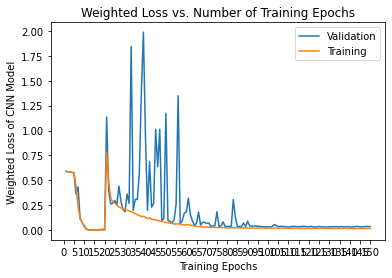

In [24]:
fname20 = "training_loss_"+str(runs)+".csv"
np.savetxt(fname20,loss_hist_train , delimiter=",")
fname21 = "validation_loss_"+str(runs)+".csv"
np.savetxt(fname21,loss_hist_val , delimiter=",")
fname22 = "learning_rate_"+str(runs)+".csv"
np.savetxt(fname22,lr_hist , delimiter=",")

shist = []
shist1 = []
train_loss = [h for h in loss_hist_train]
val_loss = [h for h in loss_hist_val]
plt.title("Weighted Loss vs. Number of Training Epochs")
plt.xlabel("Training Epochs")
plt.ylabel("Weighted Loss of CNN Model")
plt.plot(range(1,len(val_loss)+1),val_loss[0:len(val_loss)],label="Validation")
plt.plot(range(1,len(train_loss)+1),train_loss[0:len(train_loss)],label="Training")
#     plt.ylim((0.5,1.05))
plt.xticks(np.arange(0, len(val_loss)+5, 5.0))
plt.legend()
fname31 = 'loss_curve_'+str(runs)+'.png'
plt.savefig(fname31)
plt.show()

150


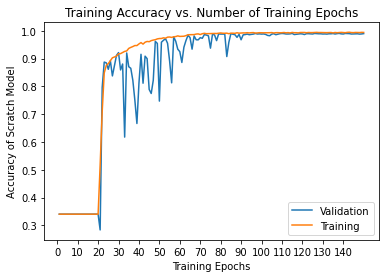

150


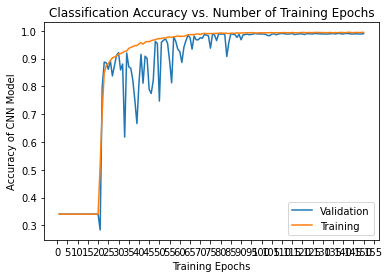

In [25]:
shist = []
shist1 = []

shist = [h.cpu().numpy() for h in scratch_hist_val]
shist1 = [h.cpu().numpy() for h in train_Bacc_hist]
print(len(shist))
plt.title("Training Accuracy vs. Number of Training Epochs")
plt.xlabel("Training Epochs")
plt.ylabel("Accuracy of Scratch Model")
plt.plot(range(1,len(shist)+1),shist[0:len(shist)],label="Validation")
plt.plot(range(1,len(shist)+1),shist1[0:len(shist)],label="Training")
# plt.ylim((0.5,1.))
plt.xticks(np.arange(0, num_epochs, 10.0))
plt.legend()
fname3 = 'training_curve_'+str(runs)+'.png'
plt.savefig(fname3)
plt.show()

shist = [h.cpu().numpy() for h in scratch_hist_val]
shist1 = [h.cpu().numpy() for h in scratch_hist_train]
print(len(shist))
plt.title("Classification Accuracy vs. Number of Training Epochs")
plt.xlabel("Training Epochs")
plt.ylabel("Accuracy of CNN Model")
plt.plot(range(1,len(shist)+1),shist[0:len(shist)],label="Validation")
plt.plot(range(1,len(shist)+1),shist1[0:len(shist)],label="Training")
# plt.ylim((0.3,1.1))
plt.xticks(np.arange(0, len(shist)+10, 5.0))
plt.legend()
fname3 = 'training_curve_'+str(runs)+'backup'+'.png'
plt.savefig(fname3)
plt.show()

In [26]:
fname6 = 'celltypemodel-unet_VeriCell3_Run_'+str(runs)+'.pth.tar'

torch.save(model.state_dict(),fname6)

150


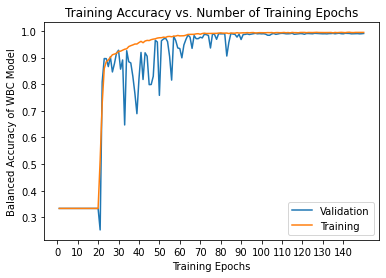

In [28]:
shist = []
shist1 = []

shist = val_Bacc_hist
shist1 = train_Bacc_hist
print(len(shist))
plt.title("Training Accuracy vs. Number of Training Epochs")
plt.xlabel("Training Epochs")
plt.ylabel("Balanced Accuracy of WBC Model")
plt.plot(range(1,len(shist)+1),shist[0:len(shist)],label="Validation")
plt.plot(range(1,len(shist)+1),shist1[0:len(shist)],label="Training")
# plt.ylim((0.5,1.))
plt.xticks(np.arange(0, num_epochs, 10.0))
plt.legend()
fname3 = 'training_curve_B'+str(runs)+'.png'
plt.savefig(fname3)
plt.show()

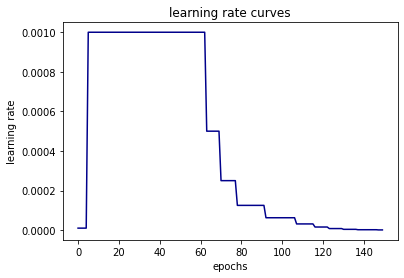

In [17]:
import pandas as pd
df = pd.read_csv (r'./learning_rate_0.csv',header=None)
LearnRate0 = df.to_numpy()
plt.figure()
plt.plot(LearnRate0,label = 'Fold-0', color='darkblue', linestyle = '-')
plt.title('learning rate curves')
plt.xlabel('epochs')
plt.ylabel('learning rate')
# plt.legend(bbox_to_anchor=(1.1, 1))
plt.show()

In [19]:
# Confusion Matrix
image_datasets = {}
image_datasets['train'] = MyDataset(trainpath)
image_datasets['val'] = MyDataset(testpath)


In [20]:
num_class = 3
in_channel = 1
out_channel = 1
num_epochs = 150
scratch_model = UNetSmallVeriCell(in_channel,out_channel,num_class)
scratch_model.load_state_dict(torch.load('celltypemodel-unet_VeriCell3_Run_0.pth.tar'))
scratch_model = scratch_model.to(device)
scratch_model.eval()

UNetSmallVeriCell(
  (dconv_down1): Sequential(
    (0): Conv2d(1, 4, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(4, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): Conv2d(4, 4, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): BatchNorm2d(4, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
  )
  (dconv_down2): Sequential(
    (0): Conv2d(4, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): Conv2d(8, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): BatchNorm2d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
  )
  (dconv_down3): Sequential(
    (0): Conv2d(8, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine

In [21]:
print("Initializing Datasets and Dataloaders...")
# Number of classes in the dataset
num_classes = 3

# Batch size for training (change depending on how much memory you have)
batch_size = 512
# Create training and validation datasets
# image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x), data_transforms[x]) for x in ['train', 'val']}
# Create training and validation dataloaders
dataloaders_dict = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=batch_size, shuffle=True, num_workers=0) for x in ['train', 'val']}

# Detect if we have a GPU available
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

Initializing Datasets and Dataloaders...


image tensor shape:  torch.Size([1, 80, 112])
image tensor dtype:  torch.float32
image tensor index:  2000
Cell Label:  Lymphocyte
image shape:  (80, 112)


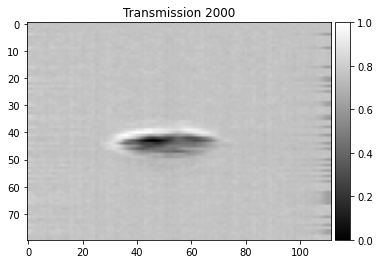

In [24]:
CellName = ['Granulocyte','Lymphocyte','Monocyte']
ImgIdx = 2000
image_datasets['val'].__getitem__(ImgIdx)[0].shape

ImgTensor = 0
ImgMask = 0
[ImgTensor,ImgLabel,ImgIdx] = image_datasets['val'].__getitem__(ImgIdx)
# image = np.transpose(ImgTensor.numpy(), (1,2,0))
# print('Cell Label: ',CellName[ImgLabel])
print('image tensor shape: ', ImgTensor.shape)
print('image tensor dtype: ', ImgTensor.dtype)
print('image tensor index: ', ImgIdx)
print('Cell Label: ',CellName[ImgLabel])

#Visualize image stacks
from mpl_toolkits.axes_grid1 import make_axes_locatable
image = 0
image = np.squeeze(ImgTensor.numpy())
print('image shape: ', image.shape)
DisplayImage(image,image.min(),image.max(),ImgIdx)

In [54]:
confusion_matrix = torch.zeros(num_classes, num_classes)
with torch.no_grad():
    for i, (inputs, classes,index1) in enumerate(dataloaders_dict['val']):
        inputs = inputs.type(torch.FloatTensor)
        inputs = inputs.to(device)
        classes = classes.to(device)
        outputs,predictions = scratch_model(inputs)
        prediction = nn.functional.log_softmax(predictions,dim=1)
        _, preds = torch.max(predictions, 1)
#         _, outputs = model(inputs)
#         _, preds = torch.max(outputs, 1)
        for t, p in zip(classes.view(-1), preds.view(-1)):
                confusion_matrix[t.long(), p.long()] += 1

print(confusion_matrix)
confusionMat = np.asarray(confusion_matrix)
sumconfusion = np.sum(confusionMat,axis = 0)
print(sumconfusion)




tensor([[1.3390e+03, 1.0000e+00, 1.8000e+01],
        [0.0000e+00, 1.0000e+03, 0.0000e+00],
        [3.0000e+00, 0.0000e+00, 1.2140e+03]])
[1342. 1001. 1232.]


In [55]:
percent_matrix = confusion_matrix/sumconfusion

percent_matrix = np.asarray(percent_matrix)
print(percent_matrix)

[[9.9776453e-01 9.9900097e-04 1.4610389e-02]
 [0.0000000e+00 9.9900103e-01 0.0000000e+00]
 [2.2354694e-03 0.0000000e+00 9.8538959e-01]]


In [56]:
import seaborn as sns
def make_confusion_matrix(cf,
                          group_names=None,
                          categories='auto',
                          count=True,
                          percent=True,
                          cbar=True,
                          xyticks=True,
                          xyplotlabels=True,
                          sum_stats=True,
                          figsize=None,
                          cmap='Blues',
                          title=None):
    '''
    This function will make a pretty plot of an sklearn Confusion Matrix cm using a Seaborn heatmap visualization.
    Arguments
    ---------
    cf:            confusion matrix to be passed in
    group_names:   List of strings that represent the labels row by row to be shown in each square.
    categories:    List of strings containing the categories to be displayed on the x,y axis. Default is 'auto'
    count:         If True, show the raw number in the confusion matrix. Default is True.
    normalize:     If True, show the proportions for each category. Default is True.
    cbar:          If True, show the color bar. The cbar values are based off the values in the confusion matrix.
                   Default is True.
    xyticks:       If True, show x and y ticks. Default is True.
    xyplotlabels:  If True, show 'True Label' and 'Predicted Label' on the figure. Default is True.
    sum_stats:     If True, display summary statistics below the figure. Default is True.
    figsize:       Tuple representing the figure size. Default will be the matplotlib rcParams value.
    cmap:          Colormap of the values displayed from matplotlib.pyplot.cm. Default is 'Blues'
                   See http://matplotlib.org/examples/color/colormaps_reference.html
                   
    title:         Title for the heatmap. Default is None.
    '''


    # CODE TO GENERATE TEXT INSIDE EACH SQUARE
    blanks = ['' for i in range(cf.size)]

    if group_names and len(group_names)==cf.size:
        group_labels = ["{}\n".format(value) for value in group_names]
    else:
        group_labels = blanks

    if count:
        group_counts = ["{0:0.1%}\n".format(value) for value in cf.flatten()]
    else:
        group_counts = blanks

    if percent:
        group_percentages = ["{0:.2%}".format(value) for value in cf.flatten()/np.tile(np.sum(cf,axis = 0),(3,))]
    else:
        group_percentages = blanks

    box_labels = [f"{v1}{v2}{v3}".strip() for v1, v2, v3 in zip(group_labels,group_counts,group_percentages)]
    box_labels = np.asarray(box_labels).reshape(cf.shape[0],cf.shape[1])


    # CODE TO GENERATE SUMMARY STATISTICS & TEXT FOR SUMMARY STATS
    if sum_stats:
        #Accuracy is sum of diagonal divided by total observations
        accuracy  = np.trace(cf) / float(np.sum(cf))
#         accuracy  = np.trace(cf) / 3
        #if it is a binary confusion matrix, show some more stats
        if len(cf)==2:
            #Metrics for Binary Confusion Matrices
            precision = cf[1,1] / sum(cf[:,1])
            recall    = cf[1,1] / sum(cf[1,:])
            f1_score  = 2*precision*recall / (precision + recall)
            stats_text = "\n\nAccuracy={:0.3f}\nPrecision={:0.3f}\nRecall={:0.3f}\nF1 Score={:0.3f}".format(
                accuracy,precision,recall,f1_score)
        else:
            stats_text = "\n\nBalanced Accuracy={:0.3f}".format(accuracy)
    else:
        stats_text = ""


    # SET FIGURE PARAMETERS ACCORDING TO OTHER ARGUMENTS
    if figsize==None:
        #Get default figure size if not set
        figsize = plt.rcParams.get('figure.figsize')

    if xyticks==False:
        #Do not show categories if xyticks is False
        categories=False


    # MAKE THE HEATMAP VISUALIZATION
    plt.figure(figsize=(3, 3), dpi=500)
    sns.set(font_scale=1.15)
    sns.heatmap(cf,annot=box_labels,fmt="",cmap=cmap,cbar=cbar,xticklabels=categories,yticklabels=categories)
    
    if xyplotlabels:
        plt.ylabel('True label')
        plt.xlabel('Predicted label' + stats_text)
    else:
        plt.xlabel(stats_text)
    
    if title:
        plt.title(title)

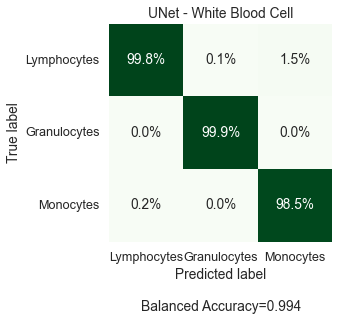

In [58]:
categories = CellName
make_confusion_matrix(percent_matrix, categories=categories,percent=False,cbar=False,figsize=(4 ,4),cmap='Greens',title = 'UNet - White Blood Cell')

In [18]:
class Flatten(nn.Module):
    def __init__(self):
        super(Flatten, self).__init__()
        
    def forward(self, x):
        return x.view(x.size(0),-1)

In [19]:
class maxpool(nn.Module):
    def __init__(self):
        super(maxpool, self).__init__()
        self.maxpool = nn.MaxPool2d(2)
        
    def forward(self, x):
        x = self.maxpool(x)
        return x

In [20]:
class relu(nn.Module):
    def __init__(self):
        super(relu, self).__init__()
        self.relu = nn.ReLU()
        
    def forward(self, x):
        x = self.relu(x)
        return x

In [21]:
num_class = 3
in_channel = 1
out_channel = 1
num_epochs = 150
scratch_model = UNetSmallVeriCell(in_channel,out_channel,num_class)
scratch_model.load_state_dict(torch.load('celltypemodel-unet_VeriCell3_Run_0.pth.tar'))
# scratch_model_fc = nn.Sequential(*(list(scratch_model.children())[:1]),maxpool(),*(list(scratch_model.children())[1:2]),maxpool(),*(list(scratch_model.children())[2:3]),maxpool(),*(list(scratch_model.children())[3:4]),maxpool(),*(list(scratch_model.children())[4:5]),Flatten())
scratch_model_fc = nn.Sequential(*(list(scratch_model.children())[0:1]),maxpool(),*(list(scratch_model.children())[1:2]),maxpool(),*(list(scratch_model.children())[2:3]),maxpool(),*(list(scratch_model.children())[3:4]),maxpool(),Flatten(),*(list(scratch_model.children())[-6:-4]),relu())
scratch_model_fc = scratch_model_fc.to(device)
scratch_model_fc.eval()

Sequential(
  (0): Sequential(
    (0): Conv2d(1, 4, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(4, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): Conv2d(4, 4, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): BatchNorm2d(4, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
  )
  (1): maxpool(
    (maxpool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (2): Sequential(
    (0): Conv2d(4, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): Conv2d(8, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): BatchNorm2d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
  )
  (3): maxpool(
    (maxpool): MaxPool2d(kernel_size=2, stride=2, padding=0,

In [22]:
image_datasets = {}
image_datasets['train'] = MyDataset(trainpath)
image_datasets['val'] = MyDataset(testpath)

In [24]:
with torch.no_grad():
    for i, (inputs, classes,imgidx) in enumerate(dataloaders_dict['val']):
        inputs = inputs.type(torch.FloatTensor)
        inputs = inputs.to(device)
        classes = classes.to(device)
        outputs = scratch_model_fc(inputs)
        outputs = outputs.cpu().clone().numpy()
        if i == 0:
            outputlist = outputs
            y = classes.cpu().clone().numpy()
        else:
            outputlist = np.append(outputlist,outputs, axis=0)
            y = np.append(y,classes.cpu().clone().numpy(), axis=0)

In [25]:
print(len(outputlist))
print(outputlist.shape)
print(y.shape)
outputlist = np.squeeze(outputlist)
print(outputlist.shape)

3575
(3575, 128)
(3575,)
(3575, 128)


In [29]:
from sklearn.manifold import TSNE
import seaborn as sns
tsne = TSNE(n_components=2, random_state=0,verbose=1, perplexity=45, learning_rate=200,early_exaggeration = 50, n_iter=500)
X_2d = tsne.fit_transform(outputlist)
CellName = ['Granulocyte','Lymphocyte','Monocyte']

[t-SNE] Computing 136 nearest neighbors...
[t-SNE] Indexed 3575 samples in 0.000s...
[t-SNE] Computed neighbors for 3575 samples in 0.274s...
[t-SNE] Computed conditional probabilities for sample 1000 / 3575
[t-SNE] Computed conditional probabilities for sample 2000 / 3575
[t-SNE] Computed conditional probabilities for sample 3000 / 3575
[t-SNE] Computed conditional probabilities for sample 3575 / 3575
[t-SNE] Mean sigma: 3.531871
[t-SNE] KL divergence after 250 iterations with early exaggeration: 379.728149
[t-SNE] KL divergence after 500 iterations: 1.166878


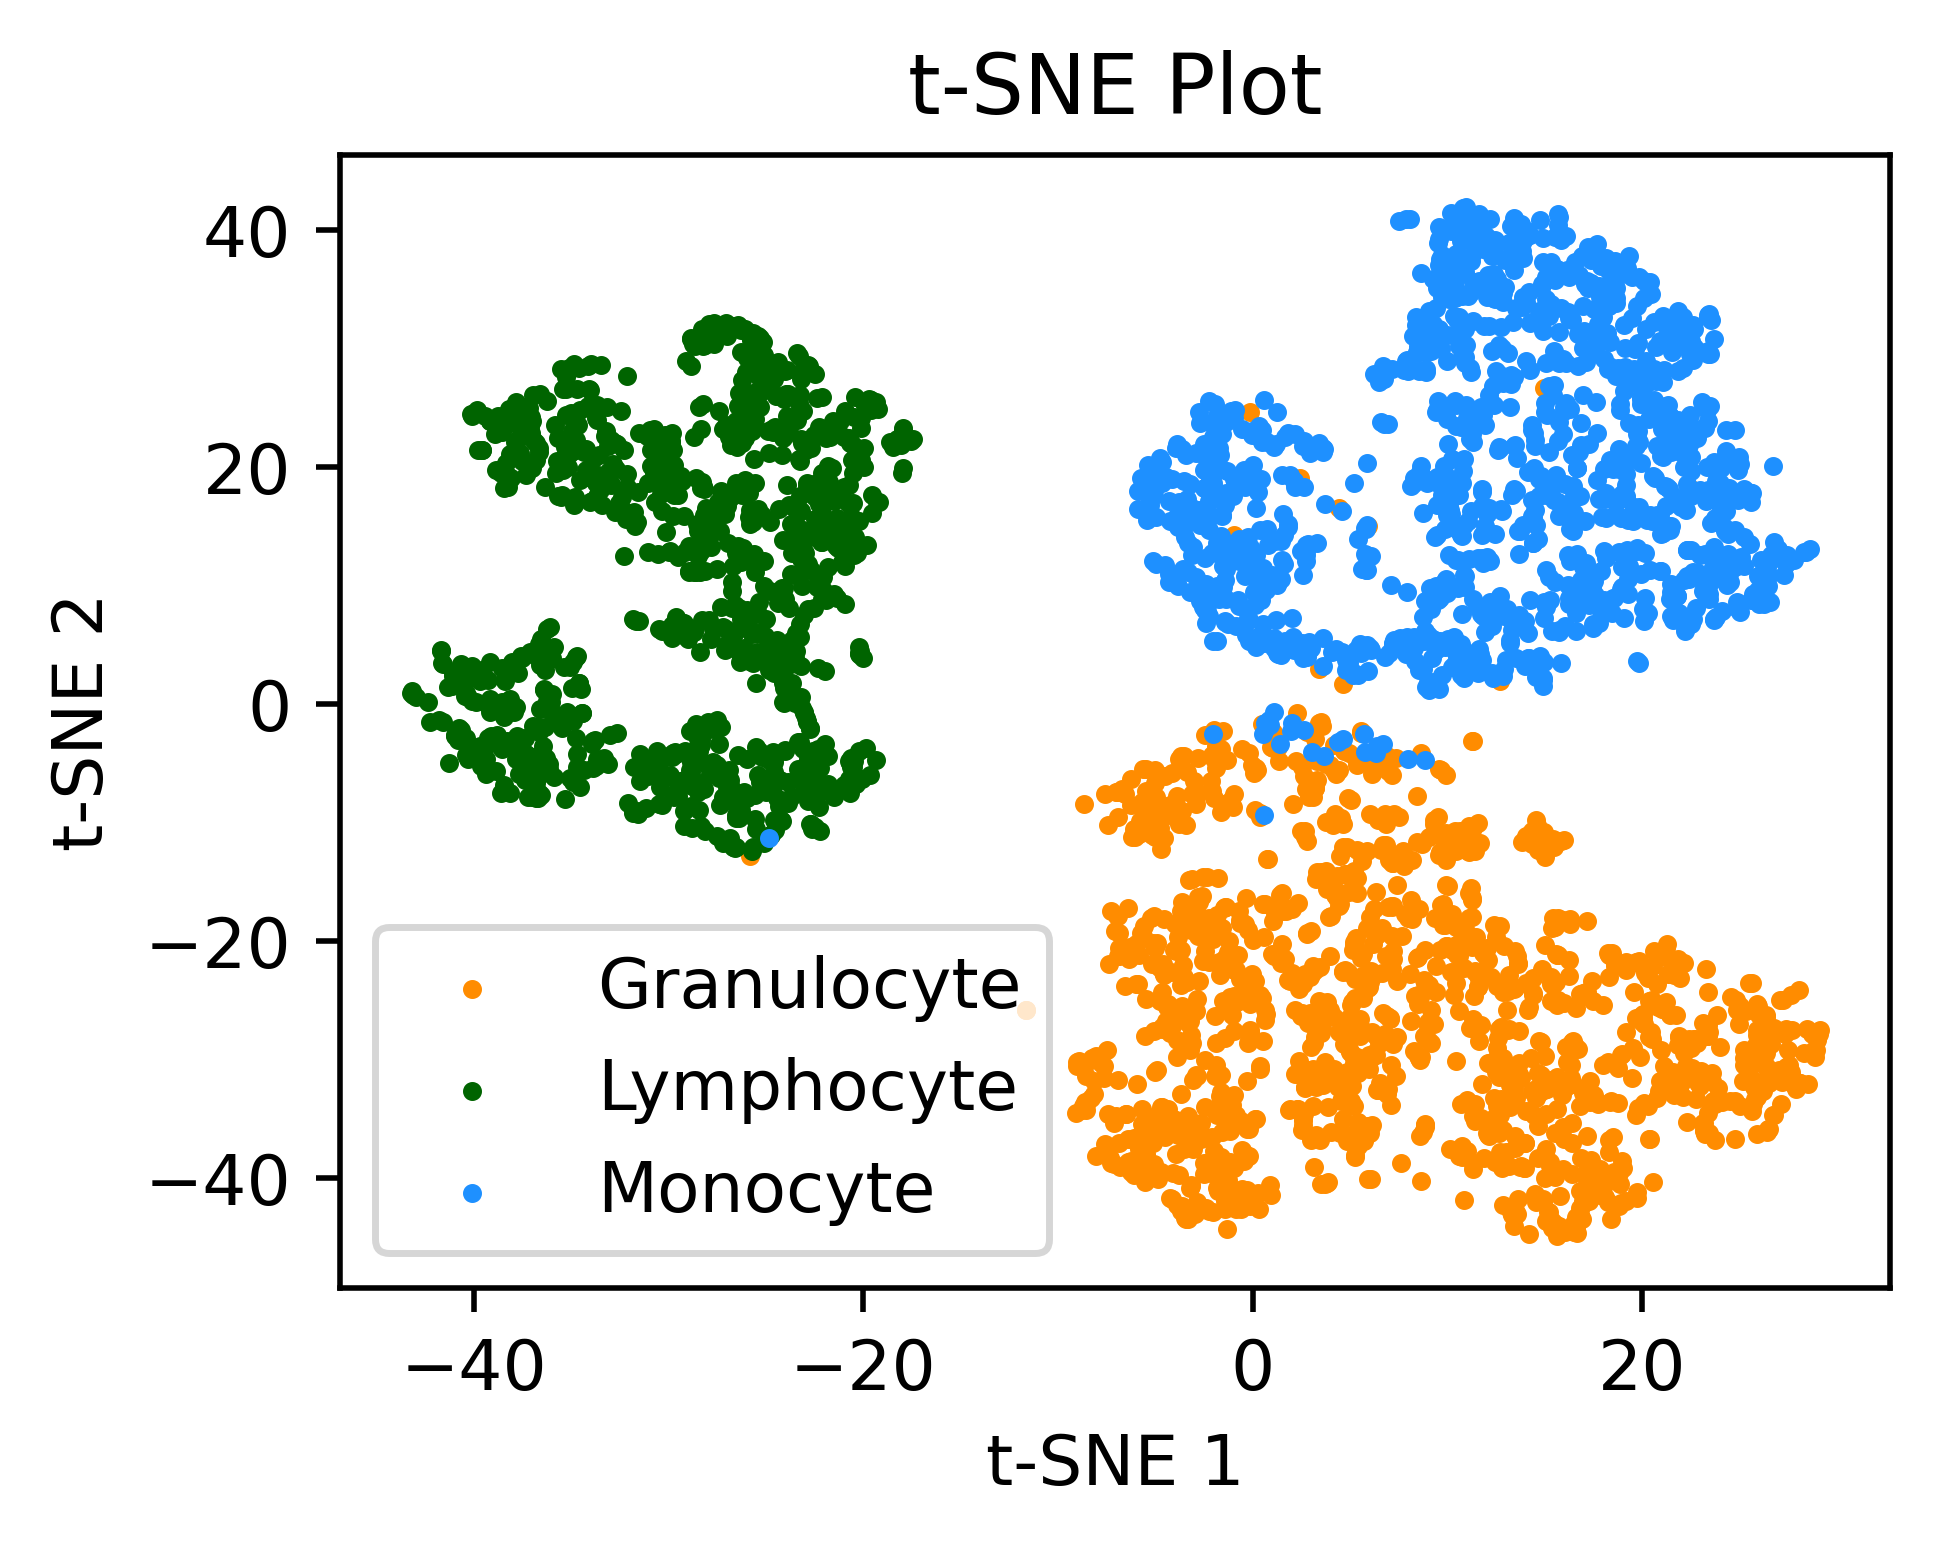

In [31]:
target_ids = range(len(outputlist))
plt.figure(figsize=(4, 3), dpi=500)
colors = 'darkorange', 'darkgreen', 'dodgerblue'
for i, c, label in zip(target_ids, colors, CellName):
    plt.scatter(X_2d[y == i, 0], X_2d[y == i, 1],s=3, c=c, label=label,alpha=1)
plt.legend()
plt.xlabel('t-SNE 1')
plt.ylabel('t-SNE 2')
plt.title('t-SNE Plot')
plt.show()